In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Try Plotly for better visuals
try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY = True
except:
    PLOTLY = False

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12,5)
sns.set_context("notebook")

DATA_DIR = Path("Data")


In [2]:
def robust_load(filepath):
    df = pd.read_csv(filepath, dtype=str)
    df.columns = [c.strip() for c in df.columns]

    # robust datetime parser
    df['datetime_raw'] = df['datetime'].astype(str).replace(r"\s+", " ", regex=True).str.strip()
    df['datetime'] = pd.to_datetime(df['datetime_raw'], dayfirst=True, errors='coerce')

    # numeric columns
    for col in ['open','high','low','close','volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


def extract_eod(df, cutoff="15:30"):
    """
    Generic EOD extractor.
    For equities use 15:30.
    For commodities use 23:59.
    """
    df = df.dropna(subset=['datetime']).copy()

    df['sec_of_day'] = (
        df['datetime'].dt.hour*3600 +
        df['datetime'].dt.minute*60 +
        df['datetime'].dt.second
    )
    df['cal_date'] = df['datetime'].dt.date

    hh, mm = map(int, cutoff.split(":"))
    cutoff_sec = hh*3600 + mm*60

    df['market_date'] = pd.to_datetime(df['cal_date'])
    mask = df['sec_of_day'] > cutoff_sec
    df.loc[mask, 'market_date'] = df.loc[mask, 'market_date'] + pd.Timedelta(days=1)

    df['eod_cutoff_ts'] = df['market_date'] + pd.to_timedelta(f"{cutoff}:00")

    valid = df[df['datetime'] <= df['eod_cutoff_ts']].copy()
    if valid.empty:
        return pd.DataFrame(columns=['date','open','high','low','close','volume'])

    idx = valid.groupby('market_date')['datetime'].idxmax()

    eod = valid.loc[idx, ['market_date','open','high','low','close','volume']].copy()
    eod['date'] = eod['market_date'].dt.date
    return eod.sort_values('date').reset_index(drop=True)


Loaded: 289482 | Datetime errors: 173758
EOD rows: 311


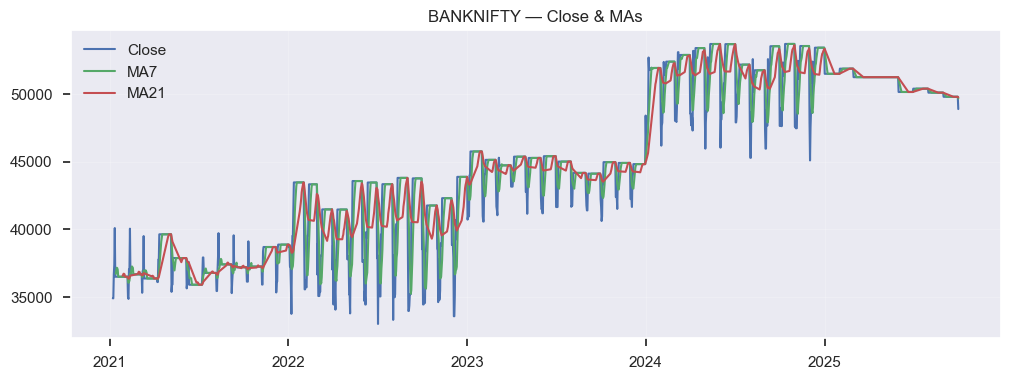

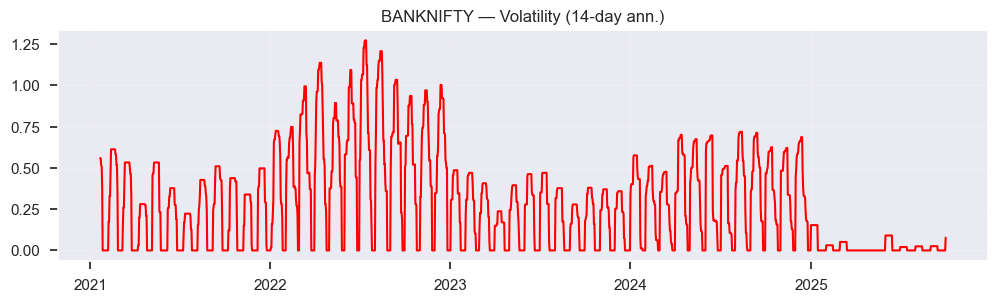

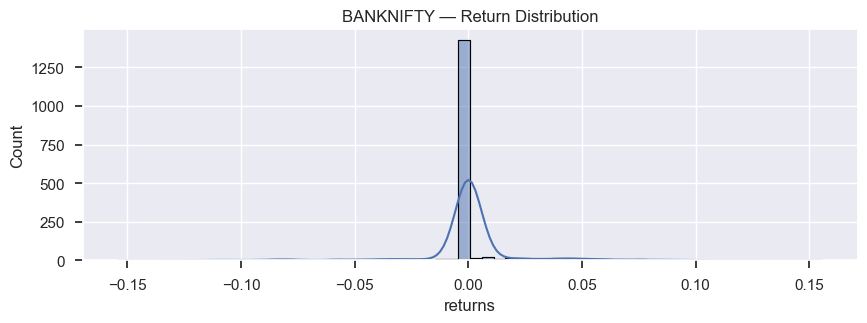

In [3]:
# BANKNIFTY Showcase
file_path = DATA_DIR / "BANKNIFTY_FUT.csv"

if not file_path.exists():
    print("BANKNIFTY file missing.")
else:
    df = robust_load(file_path)
    print("Loaded:", len(df), "| Datetime errors:", df['datetime'].isna().sum())

    eod = extract_eod(df, cutoff="15:30")
    print("EOD rows:", len(eod))

    if not eod.empty:
        ser = eod[['date','open','high','low','close','volume']].copy()
        ser['date'] = pd.to_datetime(ser['date'])
        ser = ser.set_index('date').asfreq('D')

        for col in ['open','high','low','close']:
            ser[col] = ser[col].ffill()
        ser['volume'] = ser['volume'].fillna(0)

        ser['ma7'] = ser['close'].rolling(7).mean()
        ser['ma21'] = ser['close'].rolling(21).mean()
        ser['returns'] = ser['close'].pct_change()
        ser['vol14'] = ser['returns'].rolling(14).std()*math.sqrt(252)

        # --- Price Chart ---
        plt.figure(figsize=(12,4))
        plt.plot(ser.index, ser['close'], label="Close")
        plt.plot(ser.index, ser['ma7'], label="MA7")
        plt.plot(ser.index, ser['ma21'], label="MA21")
        plt.title("BANKNIFTY — Close & MAs")
        plt.legend(); plt.grid(alpha=0.2)
        plt.show()

        # --- Volatility ---
        plt.figure(figsize=(12,3))
        plt.plot(ser.index, ser['vol14'], color='red')
        plt.title("BANKNIFTY — Volatility (14-day ann.)")
        plt.grid(alpha=0.2)
        plt.show()

        # --- Returns distribution ---
        plt.figure(figsize=(10,3))
        sns.histplot(ser['returns'].dropna(), bins=60, kde=True)
        plt.title("BANKNIFTY — Return Distribution")
        plt.show()


Loaded: 289483
EOD rows: 311


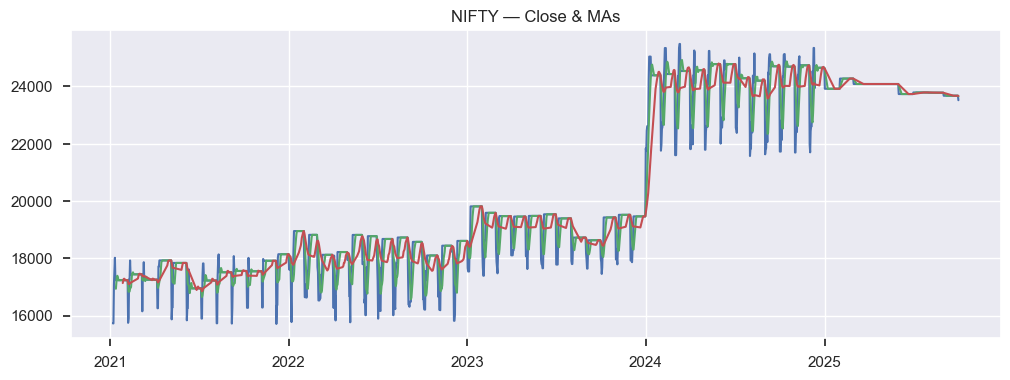

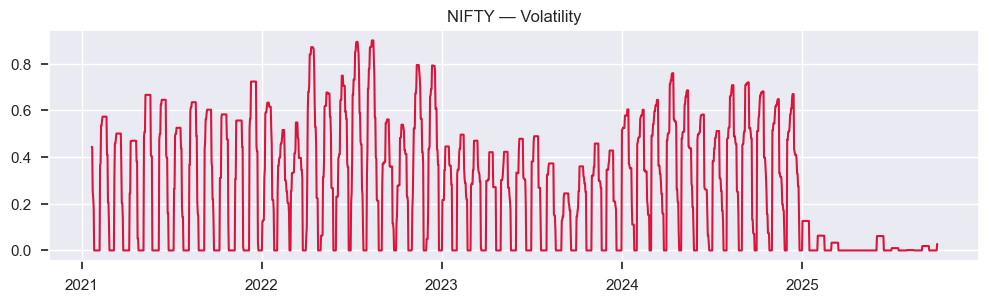

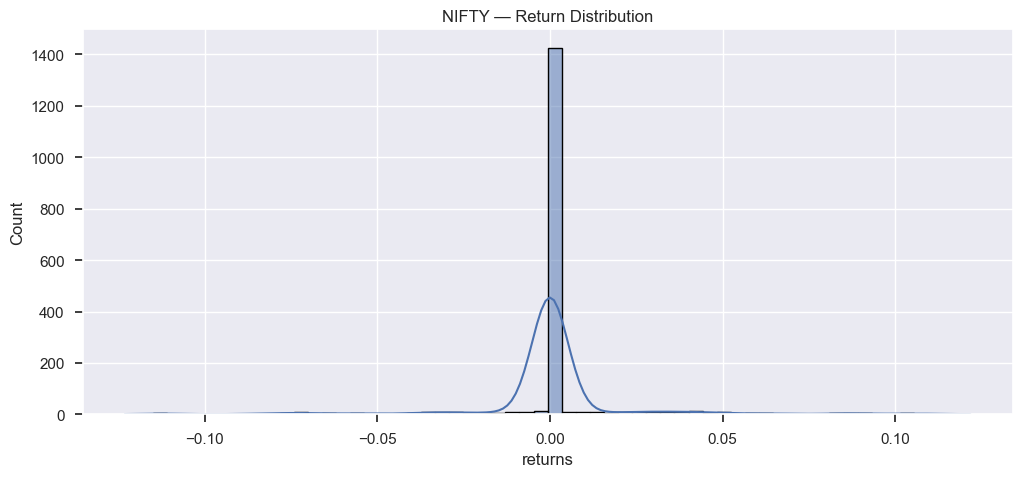

In [13]:
# NIFTY Showcase
file_path = DATA_DIR / "NIFTY_FUT.csv"

df = robust_load(file_path)
print("Loaded:", len(df))

eod = extract_eod(df, cutoff="15:30")
print("EOD rows:", len(eod))

if not eod.empty:
    ser = eod[['date','open','high','low','close','volume']].copy()
    ser['date'] = pd.to_datetime(ser['date'])
    ser = ser.set_index('date').asfreq('D').ffill()

    ser['ma7'] = ser['close'].rolling(7).mean()
    ser['ma21'] = ser['close'].rolling(21).mean()
    ser['returns'] = ser['close'].pct_change()
    ser['vol14'] = ser['returns'].rolling(14).std()*math.sqrt(252)

    plt.figure(figsize=(12,4))
    plt.plot(ser.index, ser['close'])
    plt.plot(ser.index, ser['ma7'])
    plt.plot(ser.index, ser['ma21'])
    plt.title("NIFTY — Close & MAs")
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(ser.index, ser['vol14'], color='crimson')
    plt.title("NIFTY — Volatility")
    plt.show()

    sns.histplot(ser['returns'].dropna(), bins=60, kde=True)
    plt.title("NIFTY — Return Distribution")
    plt.show()


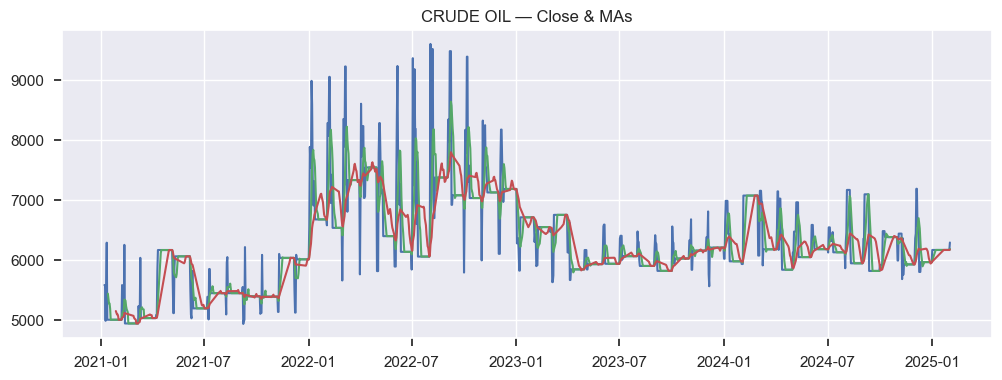

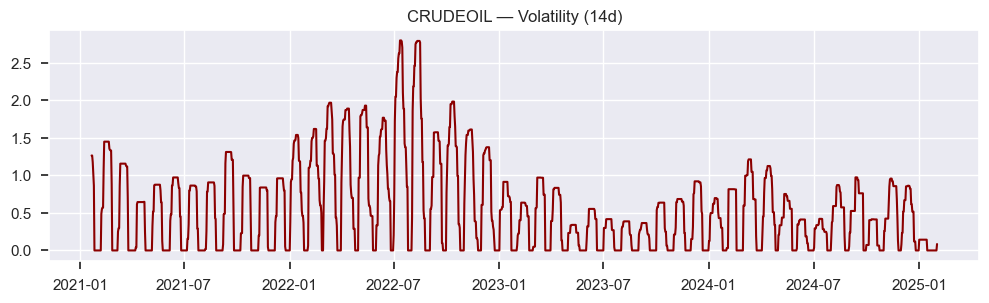

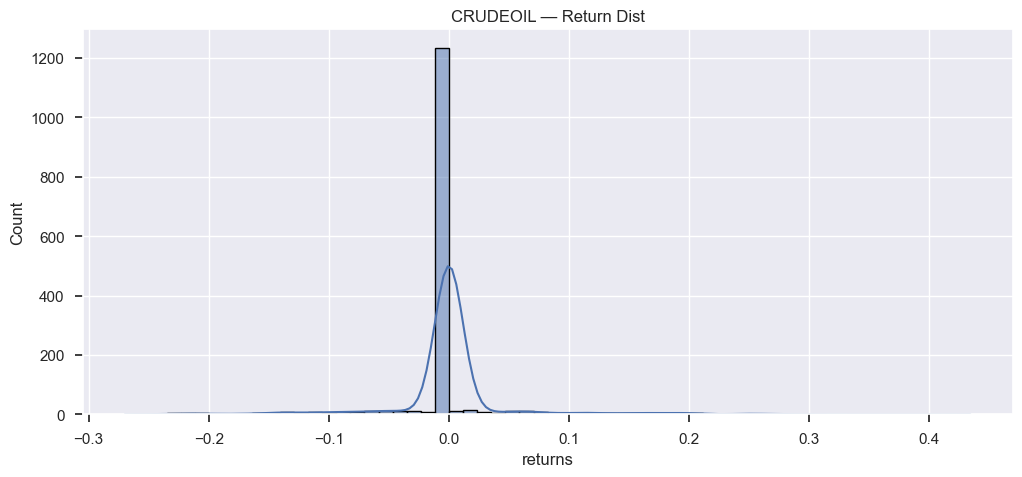

In [12]:
# CRUDEOIL Showcase
file_path = DATA_DIR / "CRUDEOIL_FUT.csv"

df = robust_load(file_path)
eod = extract_eod(df, cutoff="23:59")

ser = eod[['date','open','high','low','close','volume']].copy()
ser['date'] = pd.to_datetime(ser['date'])
ser = ser.set_index('date').asfreq('D').ffill()

ser['ma7'] = ser['close'].rolling(7).mean()
ser['ma21'] = ser['close'].rolling(21).mean()
ser['returns'] = ser['close'].pct_change()
ser['vol14'] = ser['returns'].rolling(14).std()*math.sqrt(252)

plt.figure(figsize=(12,4))
plt.plot(ser.index, ser['close'])
plt.plot(ser.index, ser['ma7'])
plt.plot(ser.index, ser['ma21'])
plt.title("CRUDE OIL — Close & MAs")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(ser.index, ser['vol14'], color='darkred')
plt.title("CRUDEOIL — Volatility (14d)")
plt.show()

sns.histplot(ser['returns'].dropna(), bins=60, kde=True)
plt.title("CRUDEOIL — Return Dist")
plt.show()


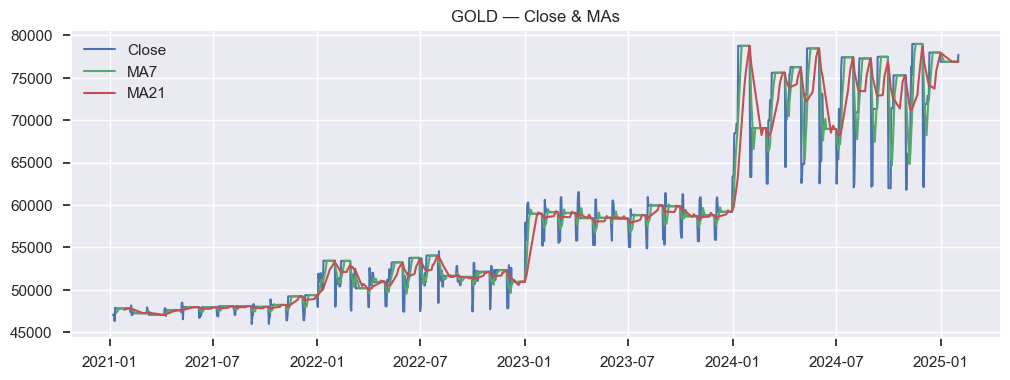

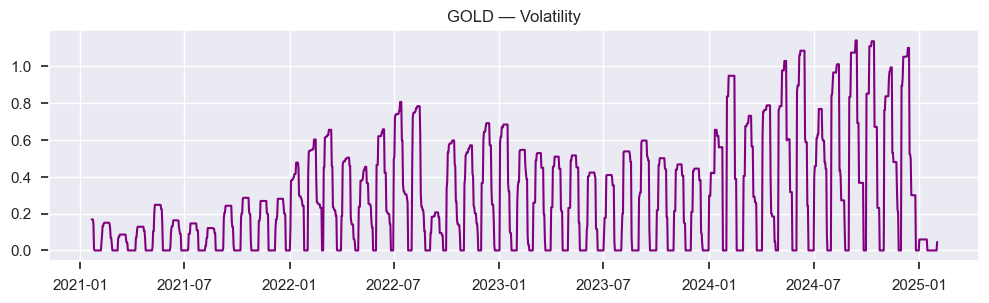

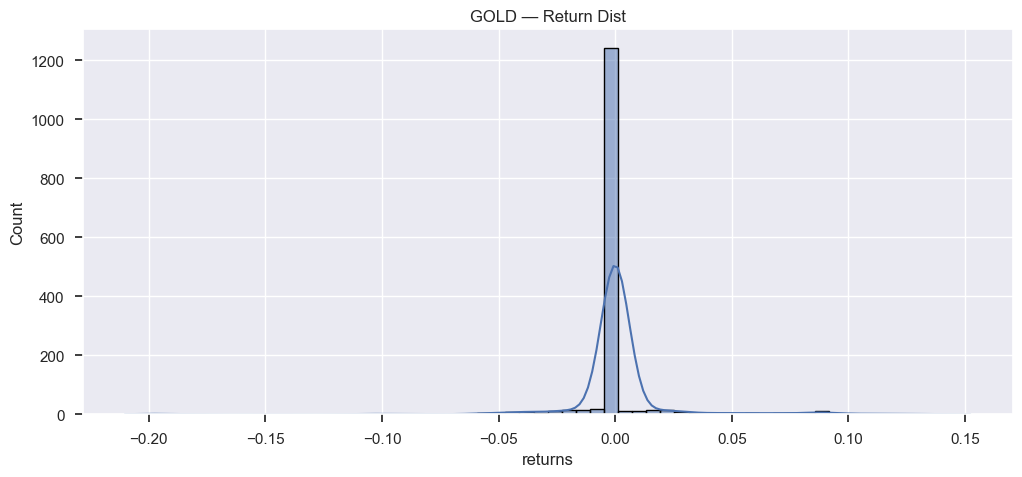

In [11]:
file_path = DATA_DIR / "GOLD_FUT.csv"

df = robust_load(file_path)
eod = extract_eod(df, cutoff="23:59")

ser = eod[['date','open','high','low','close','volume']].copy()
ser['date'] = pd.to_datetime(ser['date'])
ser = ser.set_index('date').asfreq('D').ffill()

ser['ma7'] = ser['close'].rolling(7).mean()
ser['ma21'] = ser['close'].rolling(21).mean()
ser['returns'] = ser['close'].pct_change()
ser['vol14'] = ser['returns'].rolling(14).std()*math.sqrt(252)

plt.figure(figsize=(12,4))
plt.plot(ser.index, ser['close'], label="Close")
plt.plot(ser.index, ser['ma7'], label="MA7")
plt.plot(ser.index, ser['ma21'], label="MA21")
plt.title("GOLD — Close & MAs")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(ser.index, ser['vol14'], color='purple')
plt.title("GOLD — Volatility")
plt.show()

sns.histplot(ser['returns'].dropna(), bins=60, kde=True)
plt.title("GOLD — Return Dist")
plt.show()


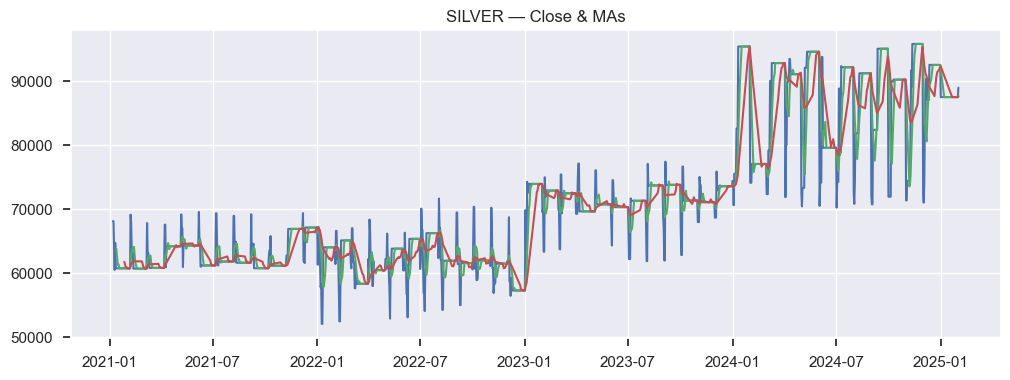

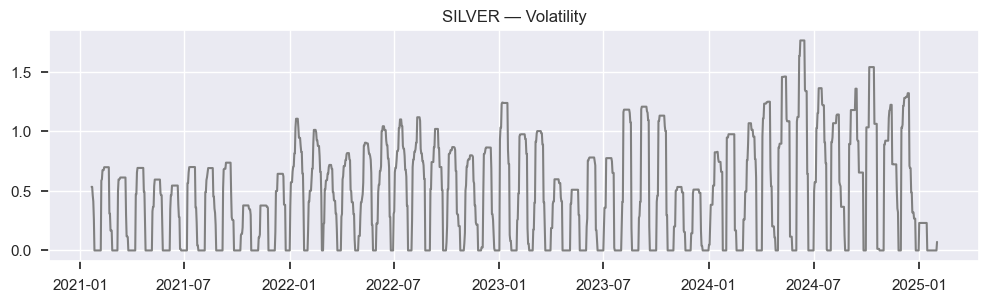

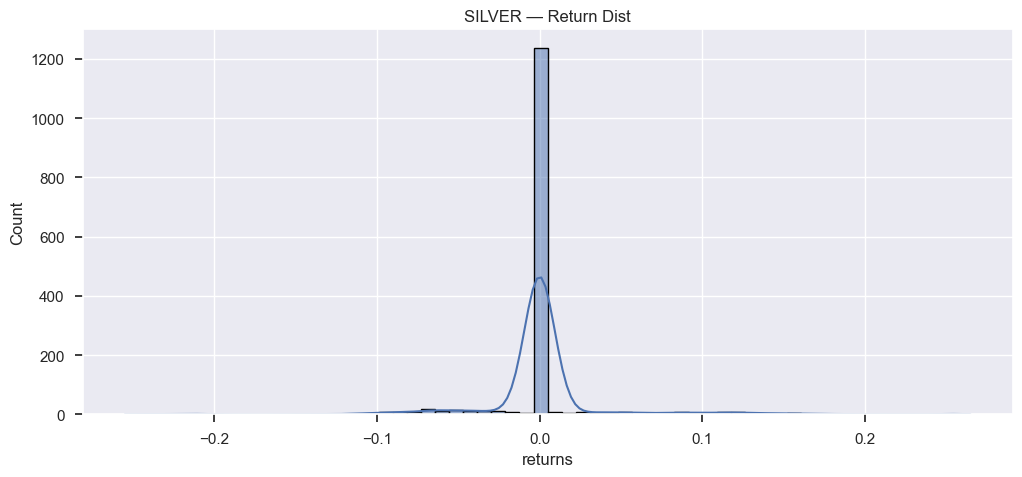

In [10]:
file_path = DATA_DIR / "SILVER_FUT.csv"

df = robust_load(file_path)
eod = extract_eod(df, cutoff="23:59")

ser = eod[['date','open','high','low','close','volume']].copy()
ser['date'] = pd.to_datetime(ser['date'])
ser = ser.set_index('date').asfreq('D').ffill()

ser['ma7'] = ser['close'].rolling(7).mean()
ser['ma21'] = ser['close'].rolling(21).mean()
ser['returns'] = ser['close'].pct_change()
ser['vol14'] = ser['returns'].rolling(14).std()*math.sqrt(252)

plt.figure(figsize=(12,4))
plt.plot(ser.index, ser['close'])
plt.plot(ser.index, ser['ma7'])
plt.plot(ser.index, ser['ma21'])
plt.title("SILVER — Close & MAs")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(ser.index, ser['vol14'], color='gray')
plt.title("SILVER — Volatility")
plt.show()

sns.histplot(ser['returns'].dropna(), bins=60, kde=True)
plt.title("SILVER — Return Dist")
plt.show()


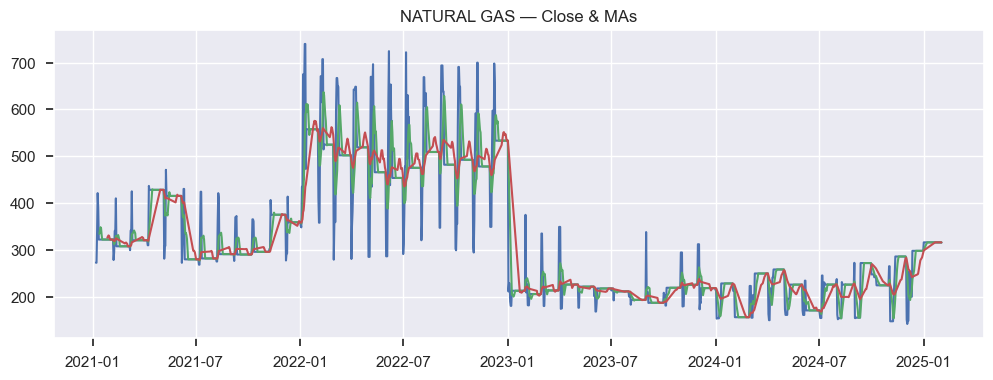

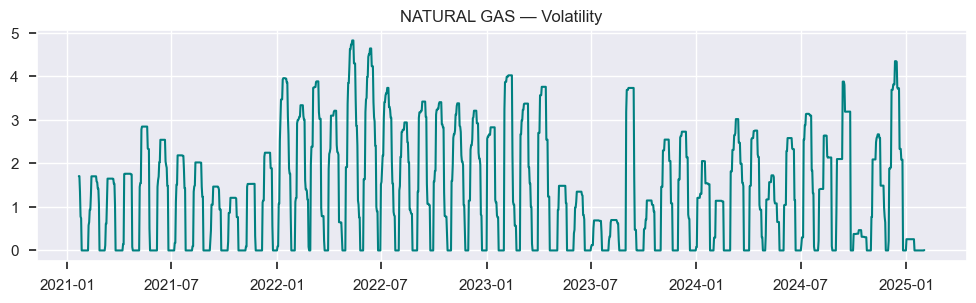

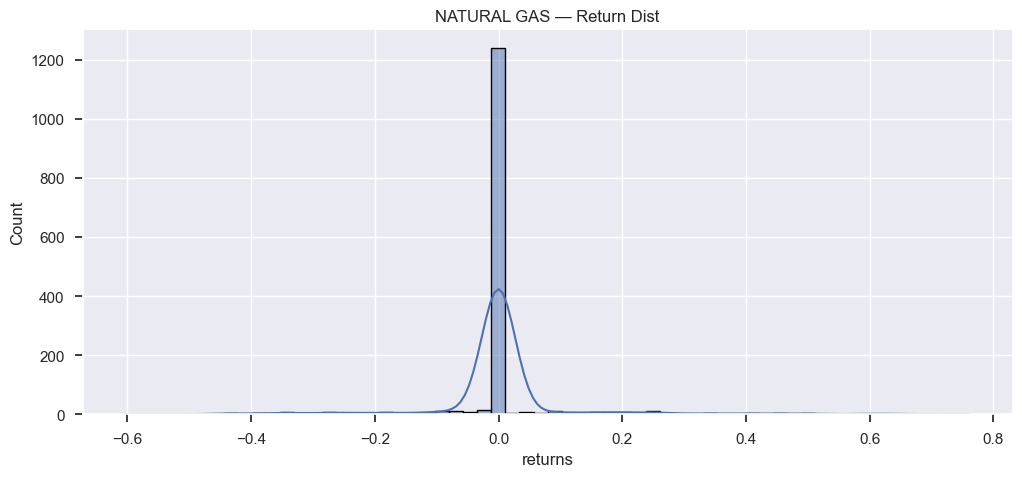

In [9]:
file_path = DATA_DIR / "NATURALGAS_FUT.csv"

df = robust_load(file_path)
eod = extract_eod(df, cutoff="23:59")

ser = eod[['date','open','high','low','close','volume']].copy()
ser['date'] = pd.to_datetime(ser['date'])
ser = ser.set_index('date').asfreq('D').ffill()

ser['ma7'] = ser['close'].rolling(7).mean()
ser['ma21'] = ser['close'].rolling(21).mean()
ser['returns'] = ser['close'].pct_change()
ser['vol14'] = ser['returns'].rolling(14).std()*math.sqrt(252)

plt.figure(figsize=(12,4))
plt.plot(ser.index, ser['close'])
plt.plot(ser.index, ser['ma7'])
plt.plot(ser.index, ser['ma21'])
plt.title("NATURAL GAS — Close & MAs")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(ser.index, ser['vol14'], color='teal')
plt.title("NATURAL GAS — Volatility")
plt.show()

sns.histplot(ser['returns'].dropna(), bins=60, kde=True)
plt.title("NATURAL GAS — Return Dist")
plt.show()
